In [1]:
# This block allows us to import from the benchmark folder,
# as if it was a package installed using pip
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from attrbench import attribution, models, datasets
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
normalize_attrs = True
aggregation_fn = "avg"

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = models.Resnet(version="resnet18", output_logits=True, num_classes=10,
                      params_loc="../data/models/CIFAR10/resnet18.pt")
model.to(device)
model.eval()
pass

In [8]:
dataset = datasets.Cifar(batch_size=4, data_location="../data/CIFAR10")
ref_dataset = dataset.get_dataloader(train=False).dataset

In [16]:
kwargs = {
    "normalize": normalize_attrs,
    "aggregation_fn": aggregation_fn
}

attribution_methods = {
    "GuidedGradCAM": attribution.GuidedGradCAM(model, model.get_last_conv_layer(), **kwargs),
    "Gradient": attribution.Gradient(model, **kwargs),
    "InputXGradient": attribution.InputXGradient(model, **kwargs),
    "IntegratedGradients": attribution.IntegratedGradients(model, **kwargs, n_steps=10),
    "smoothgrad": attribution.SmoothGrad(model, **kwargs, n_samples=30, abs=False),
    "ExpextedGradients": attribution.ExpectedGradients(model, **kwargs, n_steps=200, reference_dataset=ref_dataset),
    "GuidedBackprop": attribution.GuidedBackprop(model, **kwargs),
    "Deconvolution": attribution.Deconvolution(model, **kwargs),
}

(32, 128, 3)


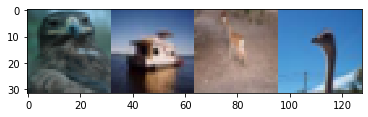

In [14]:
batch, labels = next(iter(dataset.get_dataloader(train=False)))

# Plot original images
orig_images = torch.clone(batch)
is_color = orig_images.size(1) == 3
# if color image, shape must be (batch, rows, columns, channels)
if is_color:
    orig_images = torch.transpose(orig_images, 1, 3)
# Normalize image and attribution values to [0,1]
orig_images = (orig_images - torch.min(orig_images)) / (torch.max(orig_images) - torch.min(orig_images))
orig_images = torch.flatten(orig_images, start_dim=0, end_dim=1)
orig_images = torch.transpose(orig_images, 0, 1)
orig_images = orig_images.detach().cpu().numpy()
plt.imshow(orig_images, cmap="gray" if not is_color else None)
print(orig_images.shape)

GuidedGradCAM
Gradient
InputXGradient
IntegratedGradients
smoothgrad
ExpextedGradients
GuidedBackprop
Deconvolution


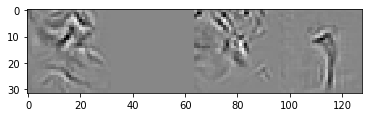

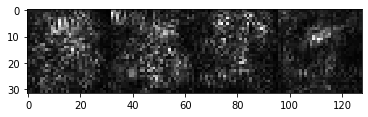

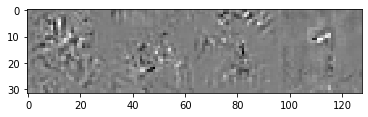

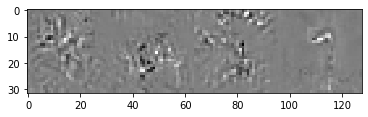

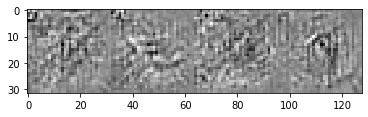

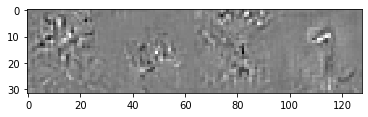

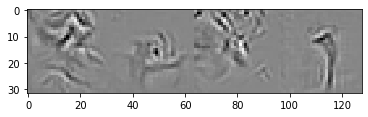

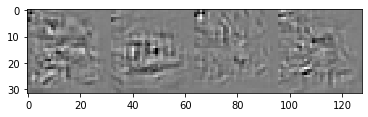

In [17]:
batch = batch.to(device)
labels = labels.to(device)
for m_name in attribution_methods:
    print(m_name)
    plt.figure()
    attrs = attribution_methods[m_name](batch, labels)
    attrs = torch.transpose(attrs, 0, 1)
    attrs = torch.flatten(attrs, start_dim=1, end_dim=2)
    attrs = attrs.detach().cpu().numpy()
    plt.imshow(attrs, cmap="gray")
    plt.show()